In [123]:
import pandas as pd 
import seaborn as sns
import numpy as np
import pickle
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import networkx as nx
import os
from tqdm.notebook import tqdm
# import warnings
# warnings.filterwarnings('ignore')

import multiprocessing as mp
from multiprocessing import cpu_count
import pickle
#mp.set_start_method('spawn')
from myfunctions import extract_freqs, calc_iter #custom functions

from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from scipy.stats import entropy
from littleballoffur import BreadthFirstSearchSampler, PageRankBasedSampler, CommunityStructureExpansionSampler

# __Cell to compile gtscanner__
You should just execute make in gtscanner directory

We have some set of datasets

In [2]:
path_to_datasets = '../datasets/'
path_to_uniform_data = '../data/'
path_to_output = '../output/'
path_to_samples = '../samples/'

functions

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Reading datasets

In [ ]:
def read_graph_data(filename, sep=',', header=None, skiprows=0):
    edgelist = pd.read_csv(os.path.join(path_to_datasets, filename), sep=sep, skiprows=skiprows, header=header, names=['source', 'target'])
    edgelist.to_csv(os.path.join(path_to_uniform_data, filename), index=False, header=None)
    return nx.from_pandas_edgelist(edgelist)

Ячейку нижу можно не запускать

In [94]:
citeseer = read_graph_data('citeseer.cites', sep='\t')
deezer_europe = read_graph_data('deezer_europe_edges.csv', header=0)
lastfm_asia = read_graph_data('lastfm_asia_edges.csv', header=0)
cora = read_graph_data('cora.cites', sep='\t')
email_Eu_core = read_graph_data('email-Eu-core.txt', sep=' ')
fb_0 = read_graph_data('0.edges', sep=' ')
fb_1 = read_graph_data('107.edges', sep=' ')
fb_2 = read_graph_data('348.edges', sep=' ')
fb_3 = read_graph_data('414.edges', sep=' ')
fb_4 = read_graph_data('686.edges', sep=' ')
fb_5 = read_graph_data('698.edges', sep=' ')
fb_6 = read_graph_data('1684.edges', sep=' ')
fb_7 = read_graph_data('1912.edges', sep=' ')
fb_8 = read_graph_data('3437.edges', sep=' ')
fb_9 = read_graph_data('3980.edges', sep=' ')
email_univ = read_graph_data('email-univ.edges', sep=' ')
fb_company = read_graph_data('fb-pages-company.edges', header=0)
fb_food = read_graph_data('fb-pages-food.edges')
fb_politician = read_graph_data('fb-pages-politician.edges')
fb_public_figure = read_graph_data('fb-pages-politician.edges')
fb_tvshow = read_graph_data('fb-pages-tvshow.edges')
soc_anybeat = read_graph_data('soc-anybeat.edges', sep=' ')
soc_hamsterster = read_graph_data('soc-hamsterster.edges', sep=' ', skiprows=2)
soc_wiki_vote = read_graph_data('soc-wiki-Vote.mtx', sep=' ', skiprows=2)
cit_DBLP = read_graph_data('cit-DBLP.edges', sep=' ', skiprows=2)

# list_of_graphs = [citeseer, deezer_europe, lastfm_asia, cora, email_Eu_core,
#                   fb_0, fb_1, fb_2, fb_3, fb_4, fb_5, fb_6, fb_7, fb_8, fb_9,
#                   email_univ, fb_company, fb_food, fb_politician, fb_public_figure,
#                   fb_tvshow, soc_anybeat, soc_hamsterster, soc_wiki_vote, cit_DBLP]
# len(list_of_graphs)

In [103]:
fb_1.number_of_edges()

26749

In [104]:
fb_1.number_of_nodes()

1034

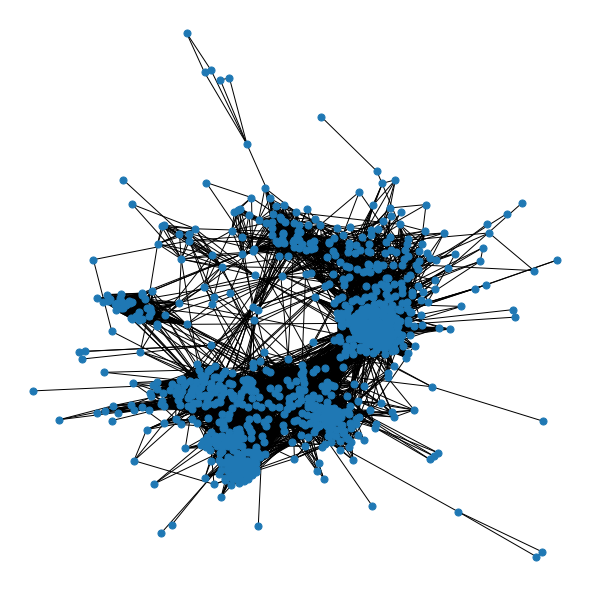

In [116]:
plt.figure(figsize=(8,8))
nx.draw(fb_1, node_size=50)

In [124]:
model = CommunityStructureExpansionSampler(int(fb_1.number_of_nodes()*0.25), seed=6123)
sampled = model.sample(nx.convert_node_labels_to_integers(fb_1))

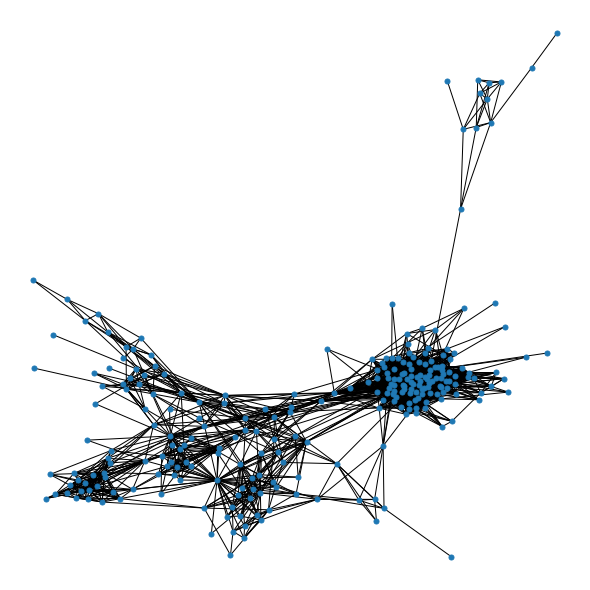

In [125]:
plt.figure(figsize=(8,8))
nx.draw(sampled, node_size=25)

## Graph classification dataset for benchmark

In [10]:
%cd ../datasets/
!wget http://nrvis.com/download/data/labeled/REDDIT-BINARY.zip
!unzip REDDIT-BINARY.zip
%cd ../notebooks/

/Users/zaikoval/Documents/GitHub/regression-on-sampling/datasets
--2020-08-30 16:02:21--  http://nrvis.com/download/data/labeled/REDDIT-BINARY.zip
Распознаётся nrvis.com (nrvis.com)… 173.236.156.25
Подключение к nrvis.com (nrvis.com)|173.236.156.25|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 9924710 (9,5M) [application/zip]
Сохранение в: «REDDIT-BINARY.zip»

REDDIT-BINARY.zip   100%[===================>]   9,46M  2,08MB/s    за 7,7s    

2020-08-30 16:02:29 (1,23 MB/s) - «REDDIT-BINARY.zip» сохранён [9924710/9924710]

Archive:  REDDIT-BINARY.zip
  inflating: REDDIT-BINARY.edges     
  inflating: readme.html             
  inflating: REDDIT-BINARY.graph_idx  
  inflating: REDDIT-BINARY.graph_labels  
  inflating: REDDIT-BINARY.readme    
/Users/zaikoval/Documents/GitHub/regression-on-sampling/notebooks


In [5]:
edges = pd.read_csv(os.path.join(path_to_datasets, 'REDDIT-BINARY.edges'), header=None, names=['source', 'target'])

In [6]:
full_graph = nx.from_pandas_edgelist(edges)

In [7]:
graph_idx = pd.read_csv(os.path.join(path_to_datasets, 'REDDIT-BINARY.graph_idx'), header=None)

In [8]:
graphs = list()
for i in tqdm(graph_idx[0].unique()):
    set_of_nodes = graph_idx[graph_idx[0] == i].index + 1
    subgraph = nx.subgraph(full_graph, set_of_nodes)
    connected_subgraph = nx.subgraph(full_graph, max(nx.connected_components(subgraph), key=len)) #extract max connected subgraph
    graphs.append(connected_subgraph)

In [15]:
graphs = graphs[:200] # take only part of graphs to make it faster

## Compute number of iterations
Можно не запускать, так как ниже есть сохраненный файл для 200 графов

In [20]:
parellel = False # change to True to compute in parallel
chunksize = 6 # vary this value to speedup parallel computation

iterations = [] 

if parellel:
    with mp.Pool(cpu_count()) as p:
        iterations = list(tqdm(p.imap(calc_iter, graphs, chunksize=chunksize), total=len(graphs)))
else:
    for elem in tqdm(graphs):
        iterations.append(calc_iter(elem))
        
#pd.DataFrame(iterations).to_csv(os.path.join(path_to_output, 'ndlib/ndlib.csv'), index=False, header=None)

/home/zaikoval/anaconda3/lib/python3.7/site-packages/ndlib/models/DiffusionModel.py:170: UserWarning: The fraction_infected value is too low given the number of nodes of the selected graph: a single node will be set as infected
  "The fraction_infected value is too low given the number of nodes of the selected graph: a "
/home/zaikoval/anaconda3/lib/python3.7/site-packages/ndlib/models/DiffusionModel.py:170: UserWarning: The fraction_infected value is too low given the number of nodes of the selected graph: a single node will be set as infected
  "The fraction_infected value is too low given the number of nodes of the selected graph: a "
/home/zaikoval/anaconda3/lib/python3.7/site-packages/ndlib/models/DiffusionModel.py:170: UserWarning: The fraction_infected value is too low given the number of nodes of the selected graph: a single node will be set as infected
  "The fraction_infected value is too low given the number of nodes of the selected graph: a "


In [20]:
ndl_data = pd.read_csv(os.path.join(path_to_output, 'ndlib/ndlib.csv'), header=None)
ndl_data

,0
0,32.9
1,40.2
2,45.9
3,38.3
4,41.6
...,...
195,38.0
196,47.4
197,38.3
198,45.7


## Compute motif distribution for graphs
Также можно не запускать, ниже готовый файл для 200 графов

In [12]:
freqs = []
for item in tqdm(graphs): 
    freqs.append(extract_freqs(item, size=4, random=10)) #already in parallel
pd.DataFrame(freqs).to_csv(os.path.join(path_to_output, 'freqs.csv'), index=False, header=None)
# pay attention to the available parameters in extract_freqs function

/Users/zaikoval/Documents/GitHub/regression-on-sampling/notebooks/myfunctions.py:51: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 51 of the file /Users/zaikoval/Documents/GitHub/regression-on-sampling/notebooks/myfunctions.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(open(os.path.join(output, 'temp.html')).read())
/Users/zaikoval/Documents/GitHub/regression-on-sampling/notebooks/myfunctions.py:88: RuntimeWarning: invalid value encountered in true_divide
  normed_freqs_4 = freqs_4 / sum_of_freqs_4


In [21]:
freqs_data = pd.read_csv(os.path.join(path_to_output, 'freqs.csv'), header=None)
freqs_data

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.023235,0.000034,0.974224,0.002493,0.000014,0.0,0.046806,-0.020803,0.655286,-0.669154,-0.346712,0.0
1,0.008805,0.000022,0.990187,0.000983,0.000003,0.0,-0.372722,0.196123,0.610110,-0.619428,-0.258243,0.0
2,0.037216,0.000047,0.956137,0.006533,0.000067,0.0,-0.424974,-0.163452,0.572081,-0.578891,-0.360956,0.0
3,0.015102,0.000026,0.982784,0.002080,0.000009,0.0,0.010402,0.093621,0.633388,-0.638012,-0.427653,0.0
4,0.019005,0.000057,0.979387,0.001545,0.000005,0.0,-0.640980,-0.016075,0.501331,-0.516401,-0.266238,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.033012,0.000077,0.962028,0.004842,0.000040,0.0,0.285519,0.042190,0.616171,-0.630889,-0.372842,0.0
196,0.244257,0.001288,0.748766,0.005635,0.000054,0.0,0.347243,0.046867,0.592231,-0.619925,-0.377068,0.0
197,0.025558,0.000049,0.972453,0.001935,0.000005,0.0,-0.520757,-0.062980,0.552717,-0.555537,-0.332758,0.0
198,0.026766,0.000060,0.971582,0.001587,0.000005,0.0,-0.366340,-0.057350,0.609786,-0.620320,-0.325376,0.0


Возможно стоит добавить несколько графов из [IMDB](http://nrvis.com/download/data/labeled/IMDB.zip) и [COLLAB](http://nrvis.com/download/data/labeled/COLLAB.zip) datasets

## Regression quality metrics on motif ditsribution of original graph 

In [22]:
freqs_data['ndlib'] = ndl_data[0]
freqs_data

,0,1,2,3,4,5,6,7,8,9,10,11,ndlib
0,0.023235,0.000034,0.974224,0.002493,0.000014,0.0,0.046806,-0.020803,0.655286,-0.669154,-0.346712,0.0,32.9
1,0.008805,0.000022,0.990187,0.000983,0.000003,0.0,-0.372722,0.196123,0.610110,-0.619428,-0.258243,0.0,40.2
2,0.037216,0.000047,0.956137,0.006533,0.000067,0.0,-0.424974,-0.163452,0.572081,-0.578891,-0.360956,0.0,45.9
3,0.015102,0.000026,0.982784,0.002080,0.000009,0.0,0.010402,0.093621,0.633388,-0.638012,-0.427653,0.0,38.3
4,0.019005,0.000057,0.979387,0.001545,0.000005,0.0,-0.640980,-0.016075,0.501331,-0.516401,-0.266238,0.0,41.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.033012,0.000077,0.962028,0.004842,0.000040,0.0,0.285519,0.042190,0.616171,-0.630889,-0.372842,0.0,38.0
196,0.244257,0.001288,0.748766,0.005635,0.000054,0.0,0.347243,0.046867,0.592231,-0.619925,-0.377068,0.0,47.4
197,0.025558,0.000049,0.972453,0.001935,0.000005,0.0,-0.520757,-0.062980,0.552717,-0.555537,-0.332758,0.0,38.3
198,0.026766,0.000060,0.971582,0.001587,0.000005,0.0,-0.366340,-0.057350,0.609786,-0.620320,-0.325376,0.0,45.7


In [23]:
for i, g in enumerate(graphs):
    n = g.number_of_nodes()
    e = g.number_of_edges()
    freqs_data.loc[i, 'nodes'] = n
    freqs_data.loc[i, 'edges'] = e
    freqs_data.loc[i, 'density'] = 2*e/(n*(n-1))

In [24]:
cross_val_score(CatBoostRegressor(iterations=100, silent=True),
                X=freqs_data.drop('ndlib', axis=1),
                y=freqs_data['ndlib'], cv=4, scoring=make_scorer(r2_score)).mean()

-0.06391323146191197

In [25]:
cross_val_score(LGBMRegressor(iterations=100, silent=True),
                X=freqs_data.drop('ndlib', axis=1),
                y=freqs_data['ndlib'], cv=4, scoring=make_scorer(mean_absolute_percentage_error)).mean()

8.793933752169243

In [25]:
# from sklearn.linear_model import LinearRegression
# cross_val_score(LinearRegression(),
#                 X=freqs_data.drop('ndlib', axis=1),
#                 y=freqs_data['ndlib'], cv=4, scoring=make_scorer(r2_score)).mean()

Quality isn't that good. We should change the dataset or add 5-motifs features

## Sampling

simple sampling for KLD plots

In [ ]:
for G in tqdm(graphs[:1]): 
    #здесь же на лету строить графики
    
    subgraph_stats = []
    
    orig_freqs = np.array(extract_freqs(G, 4))
    
    orig_n_nodes = G.number_of_nodes()
    
    #store them to list 
    #then compute ditributions
    #compute KLD, hop, and % of nodes
    #output graph
    
    for j in range(5):
        extra_hop = set()
        first_node = np.random.choice(G.nodes()s) # not just random, but only among low degree
        
        extra_hop = extra_hop.union(list(nx.neighbors(G, first_node)))
        i=1

        while (i<5) and (len(extra_hop)<G.number_of_nodes()):
            i+=1
            for node in extra_hop:
                 extra_hop = extra_hop.union(nx.neighbors(G, node))
            
            sampled_subgraph = nx.subgraph(G, extra_hop)
            
            subgraph_n_nodes = sampled_subgraph.number_of_nodes()
            
            subgraph_freqs = np.array(extract_freqs(sampled_subgraph, 4))
            
            subgraph_stats.append((entropy(orig_freqs, subgraph_freqs), i, subgraph_n_nodes / orig_n_nodes)) # sampled subgraph
            
    

In [69]:
pd.DataFrame(subgraph_stats) # можно строить графики

,0,1,2
0,inf,2,0.602804
1,3.084704e-05,3,0.850467
2,2.148446e-07,4,0.971963
3,0.000000e+00,5,1.000000
4,inf,2,0.060748
5,1.612097e-02,3,0.686916
6,1.981069e-05,4,0.887850
7,1.494576e-07,5,0.976636
8,inf,2,0.056075
9,2.096675e-02,3,0.663551


In [ ]:
for i, graph in enumerate(test_graphs): #код взят из другого ноутбука
    approx = pd.DataFrame(gt.data_4([os.path.join(hop_result_4, x) for x in result_4 if graph in x]))
    approx.set_index(0, inplace=True)
    orig = pd.DataFrame(gt.data_4([os.path.join(orig_result_4, '-' + graph+'_4.html')]))
    approx['KLD'] = approx.apply(lambda x: KLD(orig.to_numpy()[0][1:].astype(float), x), axis=1)
    approx['hop'] = [x.split('h')[1][0] for x in approx.index]
    plt.figure(figsize=(20,6));
    plt.subplot(121);
    ax1 = sns.boxplot(y='KLD', x='hop', data=approx);
    ax1.set_yscale('log')
    for file in approx.index:
        approx.loc[file, 'nodes'] = nx.from_pandas_edgelist(pd.read_csv(os.path.join(samples_hop_path, file+'.csv'), names=['source', 'target'])).number_of_nodes()
    main_n = nx.from_pandas_edgelist(pd.read_csv(os.path.join(path_to_gph, '-'+graph+'.csv'), names=['source', 'target']))
    approx['nodes'] = approx['nodes'] / main_n.number_of_nodes()
    plt.subplot(122);
    ax2 = sns.scatterplot(x='nodes', y='KLD', data=approx)
    ax2.set_yscale('log')
    print('Graph #'+str(i+1))
    print('Nodes:', main_n.number_of_nodes())
    print('Edges:', main_n.number_of_edges())

In [51]:
from littleballoffur import BreadthFirstSearchSampler

In [28]:
test_graph = graphs[0]

In [40]:
test_graph = nx.convert_node_labels_to_integers(test_graph)

In [85]:
test_graph.number_of_nodes()

214

In [90]:
model = BreadthFirstSearchSampler(int(test_graph.number_of_nodes()*0.25), seed=234)
sampled = model.sample(test_graph)

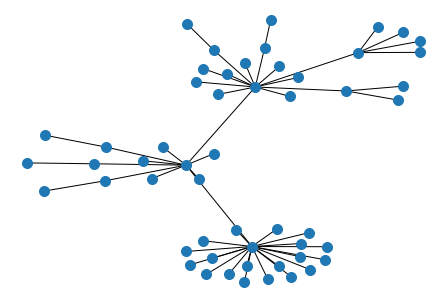

In [91]:
nx.draw(sampled, node_size=100)

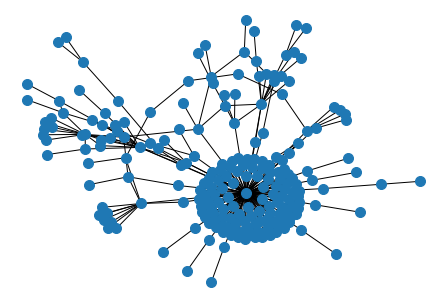

In [92]:
nx.draw(test_graph, node_size=100)

In [ ]:
model = ForestFireSampler()
model

Decide what percentage we want to take and sample it

After check regression metrics

Sample certain size of subgraphs (maybe ten) then compute motif distributions for them and check metrics

1. Берем набор для graph classification ✅
2. Считаем для него ndlib and motifs distribution (4, mb 5 if fast) ✅
3. Показываем качество исходной регрессии по нескольким метрикам на кроссвалидации ✅
4. Sample them (think how to do this right) (mb start lowest and then take only lowest or mean) (check on plots) [чтобы распределить сэмплы для каждого типо 10% от всех нод и потом можно было выбрать]
4.1 Сэмплируем специально определенный размер
5. Считаем motif distribution для них всех
5.1. Рисуем усредненный график качества по KL_Divergence
6. По параметру % нод выбираем фичи для повторной регрессии и смотрим качество и сравниваем с оригиналом
7. Добавляем density and size and check metrics
8. Сэмплим заданный размер подграфов для больших графов
9. Обучаемся на исходном датасете с доп фичами и предсказываем для больших графов с их сэмплами
10. Смотрим качество и shap